### 1. Import libraries

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from src.ViT import ViT_classifier
from src.BuildingBlocks import Patches

In [9]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### 2. Data loading and preparation

In [10]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


### 3. Hyperparameters

In [11]:
params = {
    "learning_rate" : 0.001,
    "weight_decay" : 0.0001,
    "batch_size" : 256,
    "num_epochs" : 100,
    "input_shape" : (32, 32, 3),
    "num_classes" : 100,
    "image_size" : 72,  # We'll resize input images to this size
    "patch_size" : 6,  # Size of the patches to be extract from the input images
    "projection_dim" : 64,
    "num_heads" : 4,
    "transformer_units" : [128, 64], # Size of the transformer layers
    "transformer_layers" : 8,
    "mlp_head_units" : [2048, 1024]  # Size of the dense layers of the final classifier
    }

### 4. Show patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


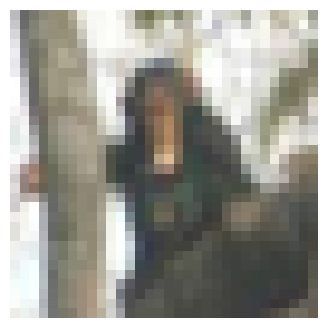

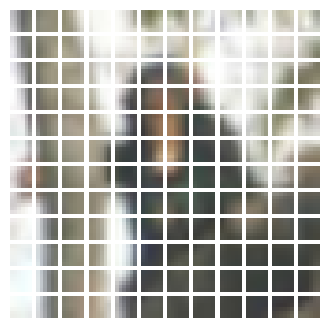

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(params["image_size"], params["image_size"])
)

extract_patches = Patches(params["patch_size"])
patches = extract_patches(resized_image)
print(f"Image size: {params['image_size']} X {params['image_size']}")
print(f"Patch size: {params['patch_size']} X {params['patch_size']}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (params["patch_size"], params["patch_size"], 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### 5. Train ViT

In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
ViT = ViT_classifier(x_train = x_train, params = params)
history = ViT.train(x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

2023-09-24 18:26:21.323553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-24 18:26:21.343011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2023-09-24 18:26:30.355935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-24 18:26:32.937909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


KeyboardInterrupt: 

In [ ]:
ViT.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 72, 72, 3)            7         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_1 (Patches)         (None, None, 108)            0         ['data_augmentation[0][0]']   
                                                                                                  
 patch_encoder (PatchEncode  (None, 144, 64)              16192     ['patches_1[0][0]']       